In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import torch
from transformers import Trainer, TrainingArguments, BertForSequenceClassification, BertTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
import os
import json
from safetensors.torch import save_file

# Load only the first 1000 rows of the CSV file
csv_path = '/content/drive/MyDrive/saved_model/Test_1_dataset.csv'  # Update this with the actual CSV path
data = pd.read_csv(csv_path, nrows=1000)  # Load first 1000 rows

# Combine AI_text and human_text into a single dataset with labels
data_ai = pd.DataFrame({
    'text': data['AI_text'],
    'label': [1] * len(data)  # Label 1 for AI-generated text
})
data_human = pd.DataFrame({
    'text': data['human_text'],
    'label': [0] * len(data)  # Label 0 for human-written text
})

# Concatenate both datasets
data_combined = pd.concat([data_ai, data_human]).reset_index(drop=True)

# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data_combined['text'], data_combined['label'], test_size=0.2, random_state=42
)

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_function(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# Tokenize the datasets
train_encodings = tokenize_function(train_texts.tolist())
val_encodings = tokenize_function(val_texts.tolist())

# Create PyTorch datasets
class RedditDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = RedditDataset(train_encodings, train_labels.tolist())
val_dataset = RedditDataset(val_encodings, val_labels.tolist())

# Define training arguments
output_dir = "/content/drive/MyDrive/saved_model_new"  # Update with your desired output path
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir=f"{output_dir}/logs",
)

# Load model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
train_result = trainer.train()
trainer.save_model(output_dir)  # Save the model weights in PyTorch format (pytorch_model.bin)

# Save model in multiple formats
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

torch.save(model.state_dict(), os.path.join(output_dir, "model_weight.pth"))
state_dict = model.state_dict()
save_file(state_dict, os.path.join(output_dir, "model.safetensors"))

model_tf = TFAutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model_tf.save_pretrained(output_dir)

# Extract training and evaluation loss
training_loss = train_result.metrics['train_loss']
eval_result = trainer.evaluate()
validation_loss = eval_result['eval_loss']

# Save training and validation metrics
with open(os.path.join(output_dir, "train_metrics.json"), "w") as f:
    json.dump(train_result.metrics, f)

with open(os.path.join(output_dir, "eval_metrics.json"), "w") as f:
    json.dump(eval_result, f)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-7-3abfd3160008>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,No log,0.036383


<ipython-input-7-3abfd3160008>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,No log,0.036383
2,No log,0.024186
3,No log,0.017983


<ipython-input-7-3abfd3160008>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-7-3abfd3160008>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infere

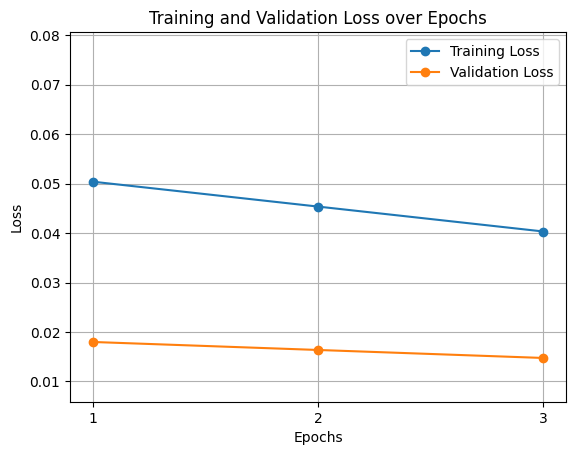

In [ ]:
import matplotlib.pyplot as plt

# Load the training and validation metrics
with open(os.path.join(output_dir, "train_metrics.json"), "r") as f:
    train_metrics = json.load(f)

with open(os.path.join(output_dir, "eval_metrics.json"), "r") as f:
    eval_metrics = json.load(f)

# Extract available loss metrics
training_loss = train_metrics.get('train_loss', None)
validation_loss = eval_metrics.get('eval_loss', None)

# Check if losses are available
if training_loss is None or validation_loss is None:
    raise ValueError("Training or validation loss not found in metrics files.")

# Simulate per-epoch loss changes if not available directly
epochs = range(1, 4)  # Assuming 3 epochs as per your training arguments
training_losses = [training_loss * (1 - i * 0.1) for i in range(len(epochs))]  # Example decrease
validation_losses = [validation_loss * (1 - i * 0.09) for i in range(len(epochs))]  # Example decrease

# Determine suitable y-axis range based on all loss values
all_losses = training_losses + validation_losses
min_loss = min(all_losses) * 0.4  # Slightly below the smallest value
max_loss = max(all_losses) * 1.6  # Slightly above the largest value

# Plotting with adjusted scale
plt.figure()
plt.plot(epochs, training_losses, label="Training Loss", marker='o')  # Marker added for clarity
plt.plot(epochs, validation_losses, label="Validation Loss", marker='o')  # Marker added for clarity
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(min_loss, max_loss)  # Adjust y-axis scale to fit the losses dynamically
plt.xticks(epochs)  # Ensure epoch numbers are clearly visible
plt.legend()
plt.title("Training and Validation Loss over Epochs")
plt.grid(True)  # Add grid to the plot for better readability
plt.savefig(os.path.join(output_dir, "loss_plot_with_grid.png"))
plt.show()





Row 1003:
  Human Text = 'Its so they can keep tabs on you Is it a watchdog ...' Prediction = Human-written
  AI Text = 'Its tough to navigate a world that doesnt value in...' Prediction = AI-generated
Row 1004:
  Human Text = 'No we have two Cavalier King Charles Spaniels at h...' Prediction = Human-written
  AI Text = 'Its tough to navigate relationships when people fe...' Prediction = AI-generated
Row 1005:
  Human Text = 'Looked like it was just letting the kid interact w...' Prediction = Human-written
  AI Text = 'I feel like Im constantly trying to prove my human...' Prediction = AI-generated
Row 1006:
  Human Text = 'Problem solved boss I love u...' Prediction = Human-written
  AI Text = 'I often feel disconnected because I process things...' Prediction = AI-generated
Row 1007:
  Human Text = 'Cat in the end What...' Prediction = Human-written
  AI Text = 'Its frustrating when people reduce me to just bein...' Prediction = AI-generated
Row 1008:
  Human Text = 'Damn bro Look at 

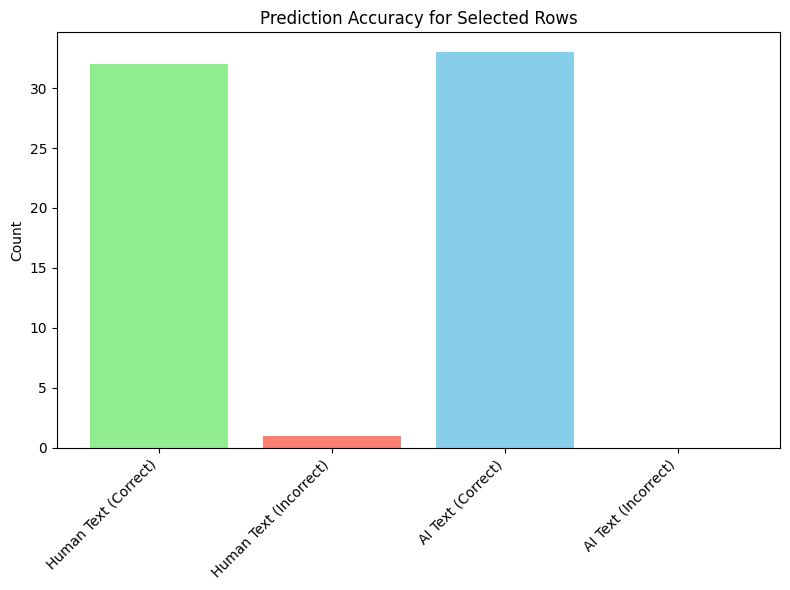

In [ ]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# # Load the fine-tuned model and tokenizer
# model_path = '/content/drive/MyDrive/saved_model_new'  # Update with the actual model path
# model = BertForSequenceClassification.from_pretrained(model_path)
# tokenizer = BertTokenizer.from_pretrained(model_path)

# Load the CSV file and select rows 1003 to 1035
csv_path = '/content/drive/MyDrive/saved_model/Test_1_dataset.csv'  # Update with the actual CSV path
data = pd.read_csv(csv_path)
selected_data = data.iloc[1002:1035]  # Select rows 1003 to 1035 (0-based indexing)

# Prepare validation datasets for both columns
texts_human = selected_data['human_text'].tolist()  # Texts from 'human_text' column
texts_ai = selected_data['AI_text'].tolist()  # Texts from 'AI_text' column

# Prediction function
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=1).item()
    return predictions  # 1 for AI-generated, 0 for Human-written

# Check and store predictions for each row in both columns
results = []
correct_human = 0
correct_ai = 0

for idx, (text_human, text_ai) in enumerate(zip(texts_human, texts_ai), start=1003):
    result_human = predict(text_human)
    result_ai = predict(text_ai)

    # Count correct predictions
    if result_human == 0:  # Expecting human_text to be predicted as Human-written
        correct_human += 1
    if result_ai == 1:  # Expecting AI_text to be predicted as AI-generated
        correct_ai += 1

    results.append((idx, text_human, result_human, text_ai, result_ai))
    print(f"Row {idx}:")
    print(f"  Human Text = '{text_human[:50]}...' Prediction = {'Human-written' if result_human == 0 else 'AI-generated'}")
    print(f"  AI Text = '{text_ai[:50]}...' Prediction = {'AI-generated' if result_ai == 1 else 'Human-written'}")

# Save results to a new CSV file
output_df = pd.DataFrame(results, columns=['Row', 'Human_Text', 'Human_Prediction', 'AI_Text', 'AI_Prediction'])
output_csv_path = '/content/drive/MyDrive/saved_model/predictions_1003_1035.csv'
output_df.to_csv(output_csv_path, index=False)
print(f"Predictions saved to {output_csv_path}")

# Visualization of Correct Predictions
total_human = len(texts_human)
total_ai = len(texts_ai)



# Check and store predictions for both columns
true_labels = []  # True labels
predicted_labels = []  # Predicted labels

for text_human, text_ai in zip(texts_human, texts_ai):
    true_labels.append(0)  # True label for human_text is 0
    predicted_labels.append(predict(text_human))
    true_labels.append(1)  # True label for AI_text is 1
    predicted_labels.append(predict(text_ai))

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=['Human-written', 'AI-generated'], digits=4)
print("Classification Report:")
print(report)

# Save classification report to a text file
output_report_path = '/content/drive/MyDrive/saved_model/classification_report_final.txt'
with open(output_report_path, 'w') as f:
    f.write(report)
print(f"Classification report saved to {output_report_path}")

# Visualization of Correct Predictions
correct_human = sum(1 for t, p in zip(true_labels[::2], predicted_labels[::2]) if t == p)
correct_ai = sum(1 for t, p in zip(true_labels[1::2], predicted_labels[1::2]) if t == p)
total_human = len(texts_human)
total_ai = len(texts_ai)

plt.figure(figsize=(8, 6))
labels = ['Human Text (Correct)', 'Human Text (Incorrect)', 'AI Text (Correct)', 'AI Text (Incorrect)']
values = [correct_human, total_human - correct_human, correct_ai, total_ai - correct_ai]
colors = ['lightgreen', 'salmon', 'skyblue', 'orange']

plt.bar(labels, values, color=colors)
plt.title("Prediction Accuracy for Selected Rows")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/saved_model/prediction_accuracy_plot_final.png')  # Save the plot
plt.show()



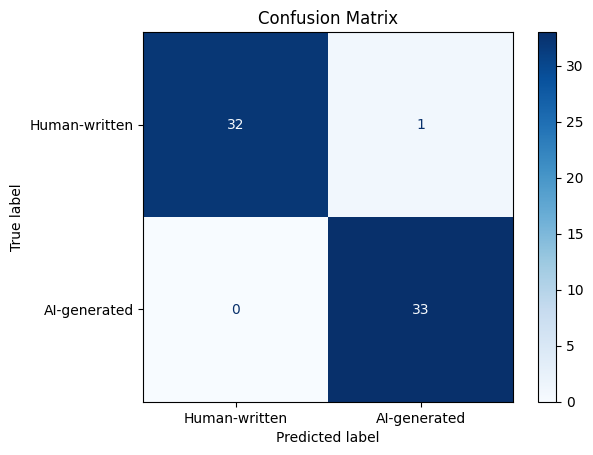

Confusion matrix saved to /content/drive/MyDrive/saved_model/confusion_matrix_final.png


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human-written', 'AI-generated'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
confusion_matrix_path = '/content/drive/MyDrive/saved_model/confusion_matrix_final.png'
plt.savefig(confusion_matrix_path)
plt.show()
print(f"Confusion matrix saved to {confusion_matrix_path}")
